# LSTM + attention mechanism for classification with keras


In [1]:
!pip install keras-self-attention

In [2]:
import pandas as pd
from csv import reader
import numpy as np
from google.colab import drive


drive.mount('/content/gdrive')

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import RepeatVector
from sklearn.model_selection import train_test_split


import keras
from keras_self_attention import SeqSelfAttention 
from keras_self_attention import SeqWeightedAttention
import keras.backend as K

import matplotlib.pyplot as plot

pd.set_option('display.max_columns', 50)
from keras.layers import Layer


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

Benign           434991
DoS              117240
DDoS              94616
Bruteforce        76190
Bot               40885
Infilteration     40484
Web_attack        16000
Name: Label, dtype: int64


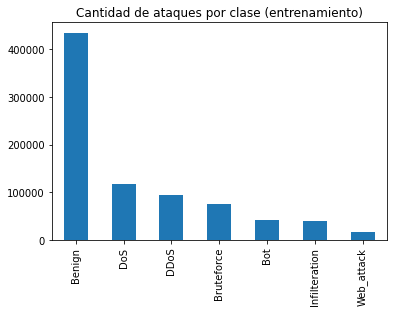

In [4]:
data = pd.read_csv("gdrive/My Drive/Doctorado/IDS data/DF_peq_full.csv",sep=",")
data.columns=['Dst Port',' Protocol',' Flow Duration',' Tot Fwd Pkts',' Tot Bwd Pkts',' TotLen Fwd Pkts',' TotLen Bwd Pkts',' Fwd Pkt Len Max',' Fwd Pkt Len Min',' Fwd Pkt Len Mean',' Fwd Pkt Len Std',' Bwd Pkt Len Max',' Bwd Pkt Len Min',' Bwd Pkt Len Mean',' Bwd Pkt Len Std',' Flow Byts/s',' Flow Pkts/s',' Flow IAT Mean',' Flow IAT Std',' Flow IAT Max',' Flow IAT Min',' Fwd IAT Tot',' Fwd IAT Mean',' Fwd IAT Std',' Fwd IAT Max',' Fwd IAT Min',' Bwd IAT Tot',' Bwd IAT Mean',' Bwd IAT Std',' Bwd IAT Max',' Bwd IAT Min',' Fwd PSH Flags',' Bwd PSH Flags',' Fwd URG Flags',' Bwd URG Flags',' Fwd Header Len',' Bwd Header Len',' Fwd Pkts/s',' Bwd Pkts/s',' Pkt Len Min',' Pkt Len Max',' Pkt Len Mean',' Pkt Len Std',' Pkt Len Var',' FIN Flag Cnt',' SYN Flag Cnt',' RST Flag Cnt',' PSH Flag Cnt',' ACK Flag Cnt',' URG Flag Cnt',' CWE Flag Count',' ECE Flag Cnt',' Down/Up Ratio',' Pkt Size Avg',' Fwd Seg Size Avg',' Bwd Seg Size Avg',' Fwd Byts/b Avg',' Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',' Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts',' Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',' Active Min', 'Idle Mean', 'Idle Std', 'Idle Max','Idle Min','Label']
colores={'Benign ': 'cadetblue','Bot': 'powederblue', 'DoS' : 'lightblue', 'Web_attack' :'deepskyblue','Bruteforce' : 'skyblue', 'DDoS' :'steelblue', 'Infilteration':'aliceblue'}
print(data['Label'].value_counts())
plot = data['Label'].value_counts().plot(kind='bar',
                                            title='Cantidad de ataques por clase (entrenamiento)')


In [5]:
X, X_Val, y, y_Val = train_test_split(data.iloc[:,0:78], data.iloc[:,-1], test_size=0.33, random_state=42)
feats = X.shape[1]

In [6]:
cant_clases=len(pd.unique(y.squeeze()))
print(cant_clases)
print(X.index[np.isinf(X).any(1)])
print(X.isna().values.any())
print (X.shape)
print(type(feats))

7
Int64Index([], dtype='int64')
False
(549672, 78)
<class 'int'>


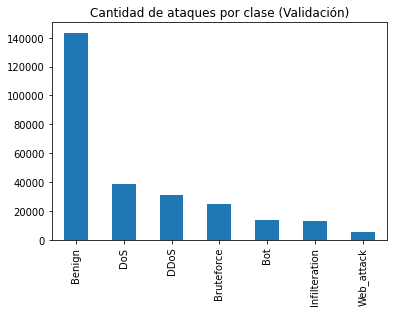

In [7]:
#X_Val=pd.read_csv("gdrive/My Drive/Doctorado/IDS data/X_Val.csv",sep=',',dtype=np.float32)
#y_Val=pd.read_csv("gdrive/My Drive/Doctorado/IDS data/y_Val.csv",sep=',')
#print (pd.unique(y_Val.squeeze()))
#print (y_Val.shape)
#print (X_Val.shape)
#indices=y_Val[y_Val['Label'] == 'Label'].index
#print (indices)

#y_Val.drop(indices, inplace=True)
#X_Val.drop(indices, inplace=True)

plot = y_Val.value_counts().plot(kind='bar',
                                            title='Cantidad de ataques por clase (Validación)')

In [8]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_enco = encoder.fit_transform(y)
y_enc = pd.DataFrame(data=y_enco)
print(y_enc.head(2))

encoder = LabelBinarizer()
y_Val_enco = encoder.fit_transform(y_Val)
y_Val_enc = pd.DataFrame(data=y_Val_enco)
print(y_Val_enc.head(2))

   0  1  2  3  4  5  6
0  0  0  0  0  1  0  0
1  1  0  0  0  0  0  0
   0  1  2  3  4  5  6
0  1  0  0  0  0  0  0
1  1  0  0  0  0  0  0


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Create minmax coef
scaler = scaler.fit(X)
#print(' Min: %f, Max: %f ' % (scaler.data_min_, scaler.data_max_))
# transform data
#X.drop(X.tail(X.shape[0]%10).index,inplace=True)
#X_Val.drop(X_Val.tail(X_Val.shape[0]%10).index,inplace=True)
#print(X.shape)
#print(X_Val.shape)


scaled_X = scaler.transform(X)
scaled_X_Val = scaler.transform(X_Val)

In [10]:
X=scaled_X.reshape((scaled_X.shape[0], 1, scaled_X.shape[1]))
print(X.shape)
X_t=scaled_X_Val.reshape((scaled_X_Val.shape[0], 1, scaled_X_Val.shape[1]))
print(X_t.shape)

(549672, 1, 78)
(270734, 1, 78)


In [11]:
def modelo():
    model = Sequential()
#    model.add(Reshape((10,78)))
#    timedistributed (10 registros por cada momento)
    model.add(LSTM(256,activation='relu',return_sequences=True,batch_size = 128,input_shape=(10,78)))
    model.add(LSTM(256,activation='relu',return_sequences=True))
#    concatenar las salidas ? concatenate
    model.add(attention())
    model.add(Dense(7))
    model.add(Dense(20))
#   model.add(Dense(cant_clases*2))
    model.add(Dense(cant_clases, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #learning rate.
    return model

In [12]:
model = modelo()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (128, 10, 256)            343040    
_________________________________________________________________
lstm_1 (LSTM)                (128, 10, 256)            525312    
_________________________________________________________________
module_wrapper (ModuleWrappe (128, 256)                266       
_________________________________________________________________
dense (Dense)                (128, 7)                  1799      
_________________________________________________________________
dense_1 (Dense)              (128, 20)                 160       
_________________________________________________________________
dense_2 (Dense)              (128, 7)                  147       
Total params: 870,724
Trainable params: 870,724
Non-trainable params: 0
__________________________________________________

In [ ]:
his=model.fit(X, y_enc, validation_data=(X_t, y_Val_enc), epochs=70, verbose=2,batch_size=128)
 #especificar batch con batch_input_shape (batch,features,?)

Epoch 1/70
4295/4295 - 45s - loss: 0.2947 - accuracy: 0.8941 - val_loss: 0.2283 - val_accuracy: 0.9148
Epoch 2/70
4295/4295 - 40s - loss: 0.2200 - accuracy: 0.9168 - val_loss: 0.2165 - val_accuracy: 0.9188
Epoch 3/70
4295/4295 - 39s - loss: 0.2140 - accuracy: 0.9187 - val_loss: 0.2115 - val_accuracy: 0.9201
Epoch 4/70
4295/4295 - 39s - loss: 0.2105 - accuracy: 0.9202 - val_loss: 0.2065 - val_accuracy: 0.9214
Epoch 5/70
4295/4295 - 39s - loss: 0.2067 - accuracy: 0.9217 - val_loss: 0.2032 - val_accuracy: 0.9236
Epoch 6/70
4295/4295 - 39s - loss: 0.2043 - accuracy: 0.9229 - val_loss: 0.2027 - val_accuracy: 0.9234
Epoch 7/70
4295/4295 - 39s - loss: 0.2024 - accuracy: 0.9237 - val_loss: 0.2072 - val_accuracy: 0.9237
Epoch 8/70
4295/4295 - 40s - loss: 0.2011 - accuracy: 0.9241 - val_loss: 0.2001 - val_accuracy: 0.9243
Epoch 9/70
4295/4295 - 40s - loss: 0.1999 - accuracy: 0.9247 - val_loss: 0.1987 - val_accuracy: 0.9279
Epoch 10/70
4295/4295 - 39s - loss: 0.1987 - accuracy: 0.9254 - val_loss:

In [ ]:
model.save('gdrive/My Drive/Doctorado/IDS data/2LSTM_ATT_3Dense.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


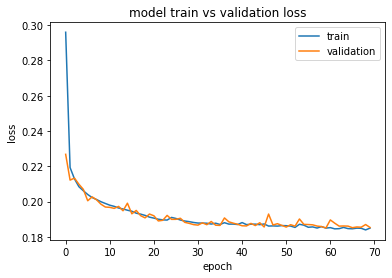

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Unrecognized location 'upper_right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


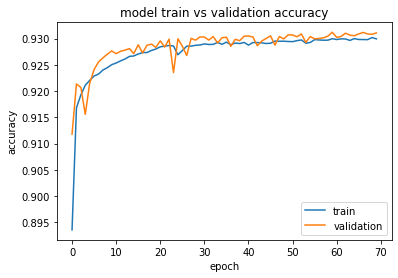

In [ ]:
import matplotlib.pyplot as plt


plt.plot(his.history['loss' ])
plt.plot(his.history[ 'val_loss' ])
plt.title( 'model train vs validation loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'validation' ], loc= 'upper_right' )
plt.show()

plt.plot(his.history['accuracy' ])
plt.plot(his.history[ 'val_accuracy' ])
plt.title( 'model train vs validation accuracy' )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'validation' ], loc= 'upper_right' )
plt.show()

In [ ]:
#https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# predict probabilities for test set
yhat_probs = model.predict(X_t, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_t, verbose=0)

yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_Val, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_Val, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_Val, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_Val, yhat_classes)
print('F1 score: %f' % f1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.000000


ValueError: ignored